# LIBS

In [1]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Input,Dropout
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import os
import numpy as np
import csv
import matplotlib.pyplot as plt

from utilities import rotate_data, squeeze_data, sequential_arm_rotation
from utilities import VIDEO_LENGTH

# Data

Parameters

In [2]:
DATA_PATH = os.path.join('model/data')
VIDEO_LENGTH # 25 frames per sequence   
MAX_ANGLE = 20 # degrees
MAX_SQUEEZE = 0.15 # 15% of the image size
MAX_ARM_ROTATION = 4
ARM_ROTATION_PROB = 3/10

Load Data

In [3]:
with open("model/custom_model_label.csv", encoding='utf-8-sig') as f:
            label_map = csv.reader(f)
            label_map = {
                row[0]: index for index, row in enumerate(label_map)
            }
            actions = list(label_map.keys())

sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(VIDEO_LENGTH):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

X = np.array(sequences)
y = to_categorical(labels).astype(int)

Split Data

In [4]:
# Step 1: separation 20% of data in val + test
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Step 2: from that 20%, use 25% as test → 25% * 20% = 5%
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.25, random_state=42)

print(f"X shape: {X.shape}, y shape: {y.shape}")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")

X shape: (210, 25, 225), y shape: (210, 7)
X_train: (168, 25, 225), y_train: (168, 7)
X_test: (11, 25, 225), y_test: (11, 7)
X_val: (31, 25, 225), y_val: (31, 7)


Augmentate Data

In [5]:
n_example = X_train.shape[0]
rot_angles = np.random.uniform(low=-MAX_ANGLE, high=MAX_ANGLE, size=n_example)
rotated  = rotate_data(X_train, rot_angles)
squeezed = squeeze_data(rotated, MAX_SQUEEZE)
arm_rotated = sequential_arm_rotation(squeezed, MAX_ARM_ROTATION, ARM_ROTATION_PROB)

print(f"X_rotated: {rotated.shape}")
print(f"X_squeezed: {squeezed.shape}")
print(f"X_arm_rotated: {arm_rotated.shape}")

AX_train = np.concatenate((X_train, arm_rotated), axis=0)
Ay_train = np.concatenate((y_train, y_train), axis=0)

print(f"AX_train shape: {AX_train.shape}, AY_train shape: {Ay_train.shape}")

X_rotated: (168, 25, 225)
X_squeezed: (168, 25, 225)
X_arm_rotated: (168, 25, 225)
AX_train shape: (336, 25, 225), AY_train shape: (336, 7)


Logs

In [6]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [7]:
np.random.randint(1, 2 + 1)



1

# MODEL

Def Model

In [8]:
model = Sequential()
model.add(Input(shape=(X.shape[1:])))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2)) 
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(len(actions), activation='softmax'))

Compile Model

In [9]:
optimizer = Adam(learning_rate=0.0001)
early_stop = EarlyStopping(
    monitor='val_loss',        # o 'val_categorical_accuracy'
    patience=8,                # numero di epoche senza miglioramento prima di fermarsi
    restore_best_weights=True # ripristina i pesi migliori
)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

Fit Model (Only When Re-Run the Model)

In [10]:
history = model.fit(AX_train, Ay_train, epochs=500, batch_size=50, validation_data=(X_val, y_val), callbacks=[early_stop])

Epoch 1/500
7/7 [==============================] - 8s 271ms/step - loss: 1.9405 - categorical_accuracy: 0.1637 - val_loss: 1.9221 - val_categorical_accuracy: 0.1935
Epoch 2/500
7/7 [==============================] - 0s 33ms/step - loss: 1.9207 - categorical_accuracy: 0.2440 - val_loss: 1.9054 - val_categorical_accuracy: 0.2903
Epoch 3/500
7/7 [==============================] - 0s 24ms/step - loss: 1.8984 - categorical_accuracy: 0.2887 - val_loss: 1.8802 - val_categorical_accuracy: 0.4516
Epoch 4/500
7/7 [==============================] - 0s 26ms/step - loss: 1.8725 - categorical_accuracy: 0.3244 - val_loss: 1.8512 - val_categorical_accuracy: 0.4839
Epoch 5/500
7/7 [==============================] - 0s 26ms/step - loss: 1.8356 - categorical_accuracy: 0.3810 - val_loss: 1.8144 - val_categorical_accuracy: 0.4194
Epoch 6/500
7/7 [==============================] - 0s 28ms/step - loss: 1.7876 - categorical_accuracy: 0.4167 - val_loss: 1.7668 - val_categorical_accuracy: 0.3871
Epoch 7/500
7/7

Trainig graph

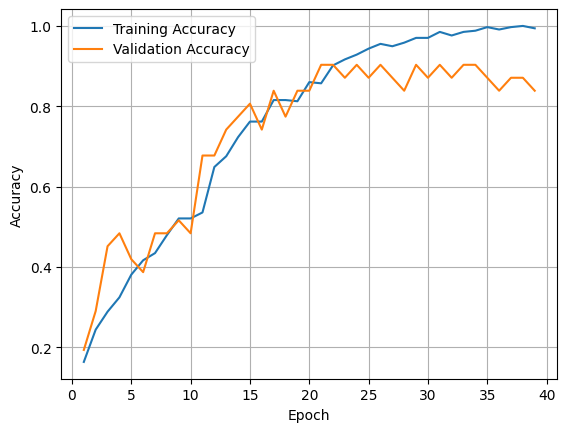

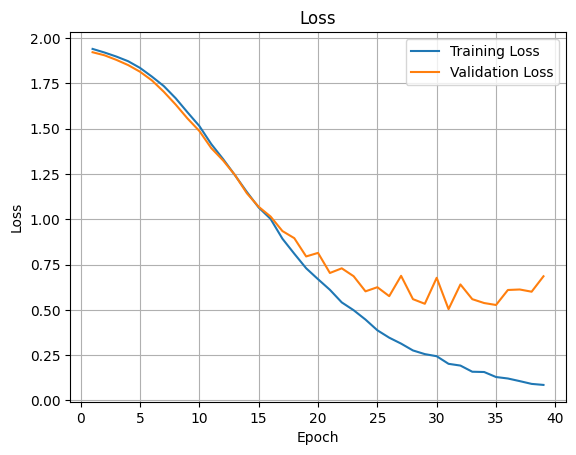

The best weights were obtained at the epoch 31 with val_loss = 0.5041


In [11]:
epochs = range(1, len(history.history['categorical_accuracy']) + 1)
plt.plot(epochs,history.history['categorical_accuracy'], label='Training Accuracy')
plt.plot(epochs,history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(epochs,history.history['loss'], label='Training Loss')
plt.plot(epochs,history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Loss')
plt.show()


val_losses = history.history['val_loss']
best_epoch = np.argmin(val_losses)
print(f"The best weights were obtained at the epoch {best_epoch + 1} with val_loss = {val_losses[best_epoch]:.4f}")

Load Model

In [12]:
# model = load_model('model/save_model.keras')

Save Model

In [13]:
model.save('model/save_model.keras')

Sumary Model

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 25, 64)            74240     
                                                                 
 lstm_1 (LSTM)               (None, 25, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 7)                 2

# Evaluation

In [15]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

Test data

In [16]:
yhat = model.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

1/1 [==============================] - 1s 1s/step


Confusion Matrix

In [17]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[ 9,  0],
        [ 0,  2]],

       [[10,  0],
        [ 0,  1]],

       [[10,  0],
        [ 1,  0]],

       [[10,  0],
        [ 0,  1]],

       [[ 8,  0],
        [ 0,  3]],

       [[ 8,  1],
        [ 0,  2]],

       [[10,  0],
        [ 0,  1]]], dtype=int64)

Accuracyt Score (1 is good, 0 bad)

In [18]:
accuracy_score(ytrue, yhat)

0.9090909090909091